This is a case based on https://ourworldindata.org/junior-data-scientist-q1-2024

In [1]:
# !pip install duckdb pandas matplotlib jupysql duckdb-engine --quiet
import duckdb
import pandas as pd
%load_ext sql
%sql duckdb:///who.db
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

# Alternatively you can skip jupysql and jupyter magics and just use 
# con = duckdb.connect('who.db')
# con.sql("SELECT table_name FROM duckdb_tables;")

Connecting to 'duckdb:///who.db'

In [2]:
%sql SELECT table_name FROM duckdb_tables;

,table_name
0,copd
1,population
2,standard_pop


In [3]:
%sql copd_df << SELECT * FROM copd;
copd_df

,age_group,USA_death_rate,UGA_death_rate
0,0-4,0.04,0.40
1,5-9,0.02,0.17
2,10-14,0.02,0.07
3,15-19,0.02,0.23
4,20-24,0.06,0.38
5,25-29,0.11,0.40
6,30-34,0.29,0.75
7,35-39,0.56,1.11
8,40-44,1.42,2.04
9,45-49,4.00,5.51


This is how you can export the two other tables into pandas dataframes if you want to use pandas.

In [4]:
%sql pop_df << SELECT * FROM population;

In [5]:
%sql standard_df << SELECT * FROM standard_pop;

Let's checkout if we have any null values in the dataset. When doing data science you always have to question the validity of the data. If your understanding of the data is not correct, you will not be able to make accurate predictions. 

For example, in this case we want to only look at the subset of data which is Uganda and USA during the year 2019. If a row has a null value in the country or year column, we will mistakenly not include that row.

In [6]:
pop_df.isna().sum().where(lambda x: x > 0).dropna()
# Notes is not of interest to us.
# Most NA values stem from a non country data grouping like Location="World"
# However, it seems like ISO3_code and ISO2_code do not always match.

Notes        1527120.0
ISO3_code     356328.0
ISO2_code     363600.0
SDMX_code      29088.0
dtype: float64

In [7]:
%%sql
-- pd_df[pd_df["ISO2_code"].isna() != pd_df["ISO3_code"].isna()].Location.unique()
SELECT 
    DISTINCT Location
FROM population
WHERE (ISO2_code IS NULL) != (ISO3_code IS NULL);

,Location
0,Namibia


It turns out Namibia has a ISO-2 code of NA. This is a problem because NA is also the default value for pandas to represent null values. This means that when we read the data into a pandas dataframe, it will interpret the NA values as null values.

Perhaps the original data was a csv and it was read by pandas,
with the default value for "NA" as None before being written to the database.

In [8]:
%%sql df_2019_US_UG <<
-- df_2019_US_UG = pd_df[(pd_df["Time"] == 2019) & (pd_df["ISO3_code"].isin(["USA", "UGA"]))]
SELECT * FROM population WHERE Time = 2019 AND ISO3_code IN ('USA', 'UGA');

In [9]:
%%sql
-- df_2019_US_UG.AgeGrpStart.unique()
SELECT DISTINCT AgeGrpStart FROM df_2019_US_UG ORDER BY AgeGrpStart DESC LIMIT 5;


,AgeGrpStart
0,100
1,99
2,98
3,97
4,96


In [10]:
%%sql
SELECT 
    age_group
FROM copd
ORDER BY age_group DESC
LIMIT 5;

,age_group
0,85+
1,80-84
2,75-79
3,70-74
4,65-69


The ages we have in the population table does not align with the age groups in the COPD table. In the COPD table we stop at "85+". The COPD table also has bins which span 5 years. Lets adjust the bins in the population table to align with the COPD table.

In [11]:
MIN_AGE = 0
MAX_AGE = 84

# We make a function because zip is a generator and we want to be able to reuse it.
start_end_tuples = lambda: zip(range(MIN_AGE, MAX_AGE+5, 5), range(MIN_AGE+5, MAX_AGE+5, 5))

bins = [list(range(start, end)) for start, end in start_end_tuples()]
names = [f"{start}-{end-1}" for start, end in start_end_tuples()]

names.append("85+")
bins.append(list(range(MAX_AGE+1, 101)))
pd.DataFrame({"age_group": names, "age_span": bins}).head()

,age_group,age_span
0,0-4,"[0, 1, 2, 3, 4]"
1,5-9,"[5, 6, 7, 8, 9]"
2,10-14,"[10, 11, 12, 13, 14]"
3,15-19,"[15, 16, 17, 18, 19]"
4,20-24,"[20, 21, 22, 23, 24]"


In [12]:
map_df = pd.DataFrame({"age_group": names, "age_span": bins, "age_group_id": range(0, len(names))})

In [13]:
%%sql binned_2019_df <<
-- map_df = map_df.explode("age_span")
-- binned_2019_df = df_2019_US_UG.merge(map_df, left_on="AgeGrpStart", right_on="age_span")
WITH age_bins AS (
    -- explode/unnest age_span
    SELECT
        age_group,
        UNNEST(age_span) AS age_span,
        age_group_id
    FROM map_df
)
SELECT * FROM df_2019_US_UG
LEFT JOIN age_bins ON df_2019_US_UG.AgeGrpStart = age_bins.age_span;

In [14]:
%%sql pivot_df <<
-- pivot_df = (binned_2019_df.assign(PopTotal=lambda x: x.PopTotal * 1000)
--     .groupby(["ISO3_code", "age_group"], as_index=False)
--     .agg({"PopTotal": "sum"})
--     .pivot(index="age_group", columns="ISO3_code", values="PopTotal")
--     # Reset index to let us use age_group as a column
--     .reset_index()
--     # Rename the pivoted columns for better description
--     .rename(columns={"USA": "USA_pop", "UGA": "UGA_pop"})
--     )
WITH pop_total AS (
    SELECT
        ISO3_code,
        age_group,
        -- The Population column is in thousands so we transform it
        SUM(PopTotal * 1000) AS PopTotal,
        age_group_id
    FROM binned_2019_df
    GROUP BY ISO3_code, age_group, age_group_id
)
SELECT * FROM pop_total
PIVOT (
    SUM(PopTotal) FOR ISO3_code IN ('USA', 'UGA')
)
ORDER BY age_group_id;


In [15]:
pivot_df.tail()

,age_group,age_group_id,USA,UGA
13,65-69,13,17500872.0,353221.0
14,70-74,14,13688596.0,197169.0
15,75-79,15,9272809.0,92681.0
16,80-84,16,6118866.0,43894.0
17,85+,17,6213955.0,19704.0


In [16]:
%%sql copd_death_df <<
SELECT * FROM copd_df JOIN pivot_df USING (age_group);

In [17]:
copd_death_df["USA_pop"] = copd_death_df["USA"]
copd_death_df["UGA_pop"] = copd_death_df["UGA"]

In [18]:
USA_deaths_COPD_100k = sum(copd_death_df["USA_death_rate"]/100_000 * copd_death_df["USA_pop"]) / sum(copd_death_df["USA_pop"]) * 100_000
print(f"USA crude death rate from COPD per 100k people: {USA_deaths_COPD_100k:.1f}")

USA crude death rate from COPD per 100k people: 57.2


In [19]:
UGA_deaths_COPD_100k = sum(copd_death_df["UGA_death_rate"]/100_000 * copd_death_df["UGA_pop"]) / sum(copd_death_df["UGA_pop"]) * 100_000
print(f"Uganda crude death rate from COPD per 100k people: {UGA_deaths_COPD_100k:.1f}")

Uganda crude death rate from COPD per 100k people: 5.8


It looks like USA has a lot death rate from COPD compared to Uganda. This is interesting because the death rate by age group is very similar, confirmed by the plot below. What's wrong with our number? It turns out that the population of the US and Uganda are different. In the US, people live longer and hence the overall death rate is higher, as risk of dying from COPD increases with age.

<Axes: xlabel='age_group'>

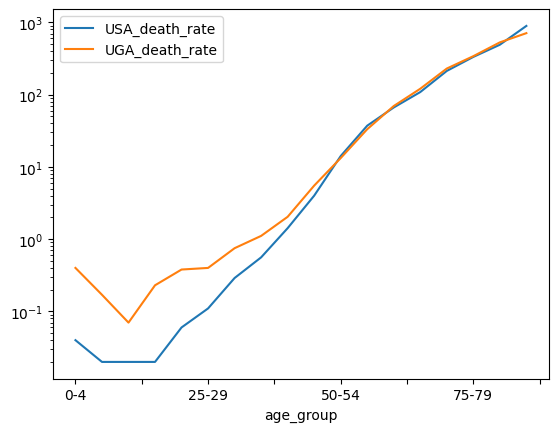

In [20]:
# We see that Uganda has a infant mortality rate higher than the USA due to COPD.
# We can also see that COPD has a higher death rate as age increases.

# Note theres also a package called sqlplot but if you are interested you can look that up yourself.
copd_df.plot(x="age_group", y=["USA_death_rate", "UGA_death_rate"], kind="line", logy=True)

<Axes: xlabel='age_group'>

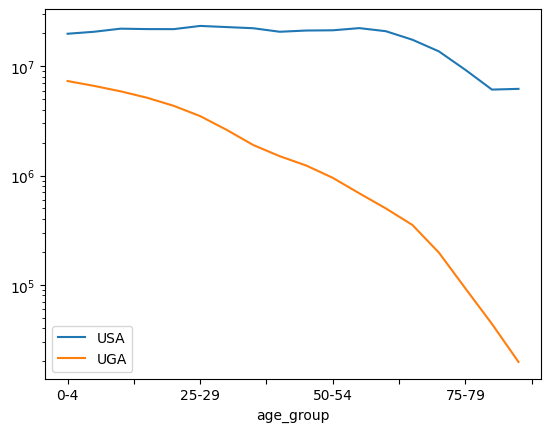

In [21]:
# We can also see that the USA has a similar population for all age groups until 85+
# meanwhile Uganda has a young population
pivot_df.plot(x="age_group", y=["USA", "UGA"], kind="line", logy=True)

What can we do to make our number tell an accurate story? We can use the world average population instead of country specific population. This will give us a better understanding of the risk of dying from COPD in a country, baked into our per 100k number.

In [22]:
%%sql standardized_df <<
-- standardized_df = copd_death_df.merge(standard_df, on="age_group")
SELECT * 
FROM copd_death_df
LEFT JOIN standard_pop 
    ON copd_death_df.age_group = standard_pop.age_group

In [23]:
standardized_df["WHO_standard_rate"] = standardized_df["WHO_Standard"] / sum(standardized_df["WHO_Standard"])

In [24]:
USA_death_rate_standardized = sum(standardized_df["USA_death_rate"] * standardized_df["WHO_standard_rate"])
print(f"USA death rate from COPD per 100k standardized: {USA_death_rate_standardized:.1f}")

USA death rate from COPD per 100k standardized: 28.4


In [25]:
UGA_death_rate_standardized = sum(standardized_df["UGA_death_rate"] * standardized_df["WHO_standard_rate"])
print(f"Uganda death rate from COPD per 100k standardized: {UGA_death_rate_standardized:.1f}")

Uganda death rate from COPD per 100k standardized: 28.7


When using the world average population we see that the death rate from COPD is higher in Uganda than in the US. This is a good example of how data can tell a different story than what you might expect.